In [4]:
import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
os.chdir('C:\\Users\\Harikrishnan.mb\\Desktop\\ML\\Unsupervised Audio Classification')
print(os.getcwd())

C:\Users\Harikrishnan.mb\Desktop\ML\Unsupervised Audio Classification


In [42]:
for i in range(1,36):
    for filename in os.listdir(f'./Speak_Recog_Data/{i}/audio'): 
        filepath=f'./Speak_Recog_Data/{i}/audio/{filename}'
        y, sr = librosa.load(filepath)        
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
        plt.figure(figsize=(6,3))
        spec=librosa.display.specshow(librosa.power_to_db(S,ref=np.max),y_axis='mel', fmax=8000,x_axis='time')
        plt.tight_layout()
        plt.axis('off')
        plt.savefig(f'./Spec/{i}/{filename[:-3]}.png',transparent=True)
        plt.clf()


C:\Users\Harikrishnan.mb\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [7]:
#convert images to array and downsampling it
#images are converted to greyscale
from matplotlib.image import imread
from skimage import transform
image_list=[]
label_list=[]

for i in range(1,36):    
    for filename in os.listdir(f'./Spec/{i}'): 
        img_path=f'./Spec/{i}/{filename}'
        img = imread(img_path)
        img=transform.pyramid_reduce(img,downscale=4,multichannel=False)
        image_list.append(img)
        label_list.append(i)

In [23]:
X=np.array(image_list)
y=np.array(label_list)
X.shape

(350, 54, 108, 1)

In [24]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y)

#x_train = x_train.astype('float32') / 255.
#x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
#x_test = x_test.astype('float32') / 255.
#x_test = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))

In [25]:
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers

batch_size = 32
epochs = 200
input_img = Input(shape=(54, 108, 1))
num_classes = 35

In [30]:
def encoder(input_img):
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) 
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    return conv2

In [39]:
def decoder(conv2):    
        
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2) 
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv3 = BatchNormalization()(conv3)
    up1 = UpSampling2D((2,2))(conv3) 
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) 
    conv4 = BatchNormalization()(conv4)
    #conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv4)
    #conv4 = BatchNormalization()(conv4)
    #up2 = UpSampling2D((2,2))(conv4) 
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(conv4) 
    return decoded

In [40]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 54, 108, 1)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 54, 108, 32)       320       
_________________________________________________________________
batch_normalization_49 (Batc (None, 54, 108, 32)       128       
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 54, 108, 32)       9248      
_________________________________________________________________
batch_normalization_50 (Batc (None, 54, 108, 32)       128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 27, 54, 32)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 27, 54, 64)        18496     
__________

In [42]:
autoencoder_train = autoencoder.fit(x_train, x_train, batch_size=16,epochs=50,
                                    verbose=1,validation_data=(x_test, x_test))

Train on 280 samples, validate on 70 samples
Epoch 1/50
240/280 [========================>.....] - ETA: 8s - loss: 0.0088 

KeyboardInterrupt: 

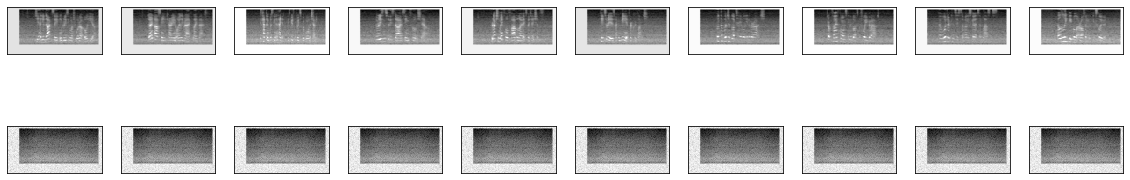

In [14]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].reshape(54, 108))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(54, 108))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()